In [1]:
include("../src/Hydro.jl");

In [2]:
using .Hydro
using CSV
using DataFrames
using Printf: @sprintf

# Load some data

In [3]:
# load a test dataset from a CSV file into a dataframe
df = CSV.read("../test/data/test_2_data.csv", header=1, missingstrings=["-9999"]);

In [54]:
size(df)

(12417, 5)

In [52]:
len = @sprintf("%.1f", size(df)[1] / 365)
println("Period of record is $len years")

Period of record is 34.0 years


In [5]:
names(df)

5-element Array{Symbol,1}:
 :date            
 :obs_rain        
 :obs_pet         
 :obs_runoff      
 :obs_runoff_sim_0

In [6]:
# rename the columns
names!(df, Symbol.(["date", "obs_rain", "obs_pet", "obs_runoff", "test_sim_runoff"]));

In [7]:
# Create a dictionary of data from the dataframe - standard data structure through Hydro
data = Dict()
data["rain"] = df[:obs_rain]
data["pet"] = df[:obs_pet]
data["runoff_obs"] = df[:obs_runoff]
data["runoff_sim_test"] = df[:test_sim_runoff];

# Calibrate GR4J parameters

- GR4J model with NSE objective function (minimised so -ve)
- Differential evolution optimiser with adaptive weights over a limited radius
- Take best parameter set after 3 minutes
- Display best sample every 15 seconds

Available methods: https://github.com/robertfeldt/BlackBoxOptim.jl#existing-optimizers

In [8]:
# build up dictionary of model functions needed for calibration
functions = Dict()
functions["run_model_time_step"] = gr4j_run_step
functions["init_state"] = gr4j_init_state
functions["params_from_array"] = gr4j_params_from_array
functions["objective_function"] = (obs, sim) -> -1 * nse(obs, sim)
functions["params_inverse_transform"] = gr4j_params_trans_inv
functions["params_range_transform"] = gr4j_params_range_trans
functions["params_range_to_tuples"] = gr4j_params_range_to_tuples

gr4j_params_range_to_tuples (generic function with 1 method)

In [32]:
# build up dictionary of optimiser options needed for calibration
opt_options = Dict()
opt_options["max_iterations"] = false
opt_options["max_time"] = 5 * 60
opt_options["trace_interval"] = 15
opt_options["method"] = :adaptive_de_rand_1_bin_radiuslimited  # 0.83
#opt_options["method"] = :adaptive_de_rand_1_bin # 0.80
#opt_options["method"] = :de_rand_1_bin_radiuslimited # 0.83
#opt_options["method"] = :de_rand_1_bin # 0.80
#opt_options["method"] = :generating_set_search # 0.83

15

In [33]:
opt_pars, opt_nse = calibrate(functions, opt_options, data, gr4j_params_range())
opt_nse *= -1

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.RangePerDimSearchSpace}}
0.00 secs, 0 evals, 0 steps
15.02 secs, 71 evals, 38 steps, improv/step: 0.605 (last = 0.6053), fitness=-0.509863392
30.17 secs, 143 evals, 93 steps, improv/step: 0.548 (last = 0.5091), fitness=-0.703664760
45.34 secs, 216 evals, 147 steps, improv/step: 0.537 (last = 0.5185), fitness=-0.703664760
60.50 secs, 287 evals, 204 steps, improv/step: 0.490 (last = 0.3684), fitness=-0.703664760
75.64 secs, 359 evals, 272 steps, improv/step: 0.460 (last = 0.3676), fitness=-0.703664760
90.79 secs, 431 evals, 343 steps, improv/step: 0.423 (last = 0.2817), fitness=-0.723481029
106.00 secs, 502 evals, 413 steps, improv/step: 0.409 (last = 0.3429), fitness=-0.723481029
121.02 secs, 572 evals, 481 steps, improv/step: 0.391 (last = 0.2794), fitness=-0.723481029
136.1

0.824823205081413

In [36]:
opt_pars

Dict{String,Float64} with 4 entries:
  "x1" => 28.6848
  "x4" => 1.30992
  "x2" => -2.51026
  "x3" => 332.53

In [34]:
# test parameters were
gr4j_params_from_array(CSV.read("../test/data/test_2_params.csv", delim=":", header=0)[2])

Dict{String,Float64} with 4 entries:
  "x1" => 55.0616
  "x4" => 1.49495
  "x2" => -0.039867
  "x3" => 249.783

# Simulate using these calibrated parameters

In [37]:
init_state = gr4j_init_state(opt_pars)

Dict{String,Any} with 6 entries:
  "uh2"              => [0.0, 0.0, 0.0, 0.0]
  "production_store" => 0
  "uh2_ordinates"    => [0.254601, 0.668388, 0.077011, 0.0]
  "routing_store"    => 0
  "uh1"              => [0.0, 0.0]
  "uh1_ordinates"    => [0.509201, 0.490799]

In [38]:
data = simulate(gr4j_run_step, data, opt_pars, init_state);

In [39]:
keys(data)

Base.KeySet for a Dict{Any,Any} with 5 entries. Keys:
  "runoff_sim"
  "pet"
  "rain"
  "runoff_obs"
  "runoff_sim_test"

# Plot a hydrograph of this simulation with test simulation

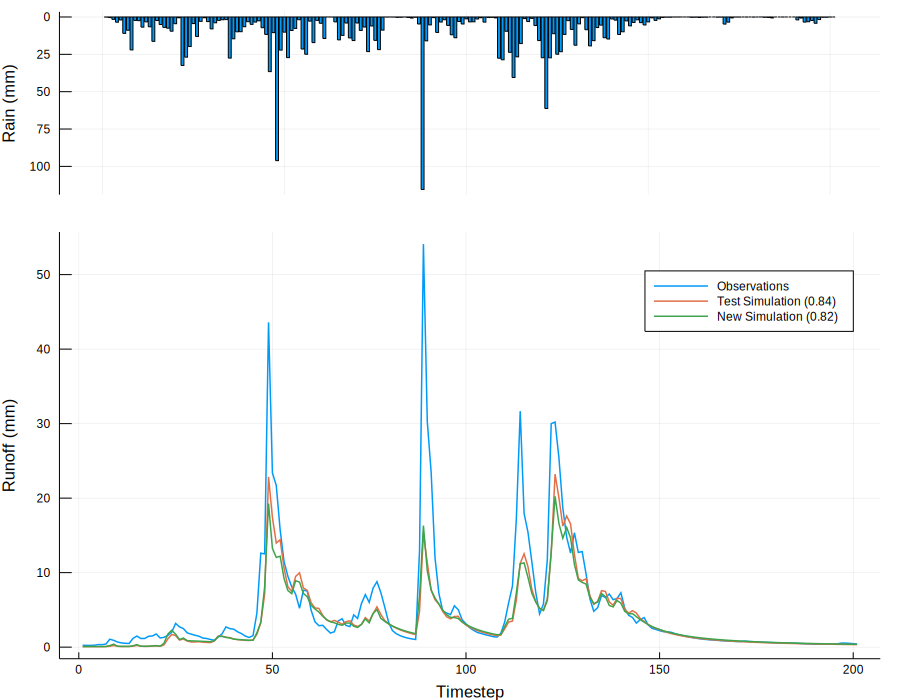

In [40]:
s, e = 12000, 12200

obs = data["runoff_obs"][s:e]
test = data["runoff_sim_test"][s:e]
sim = data["runoff_sim"][s:e]
rain = data["rain"][s:e]

nse_test = @sprintf("%.2f", nse(data["runoff_obs"], data["runoff_sim_test"]))
nse_sim = @sprintf("%.2f", nse(data["runoff_obs"], data["runoff_sim"]))

hydrograph(rain, [obs, test, sim], ["Observations", "Test Simulation ($nse_test)", "New Simulation ($nse_sim)"])